# Settings

In [8]:
from pathlib import Path

import pandas as pd
pd.plotting.register_matplotlib_converters()
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb

In [21]:
syntanic_data_path = Path(r'.\data\train.csv')
syntanic_data = pd.read_csv(syntanic_data_path, index_col='PassengerId')
syntanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


# Context

Здесь использован синтетический набор данных, но основан на реальных данных с Титаника.

В данных следующие колонки: ``` ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'] ```, а ```'PassengerId'``` использован как индекс строки.

# Data quality assessment

Количество строк в данных 100000
Среди колонок наибольшее количество пропущенных значений имеет номер кабины ('Cabin' = 67.87%), далее номер билета ('Ticket' = 4.62%) и возраст ('Age' = 3.29%), а наименьшее - порт назначения ('Embarked' = 0.25%) и тариф ('Fare' = 0.13%). В остальных колонках нет пропущенных значений.
При этом во всем датасете обнаружено 0 полностью пустых строк


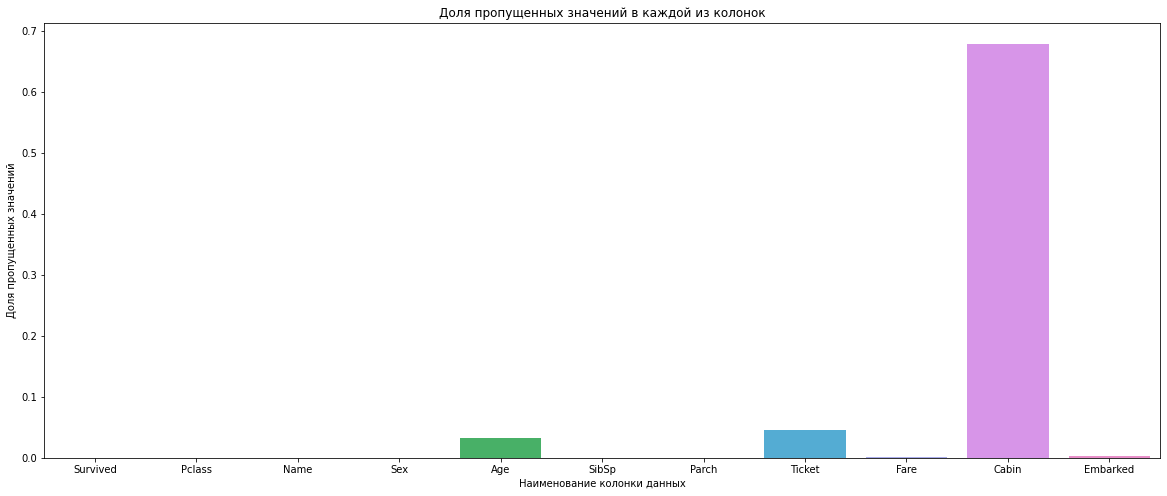

In [62]:
total_rows = syntanic_data.shape[0]
print(f'Количество строк в данных {syntanic_data.shape[0]}')

plt.figure(figsize=(20, 8))
plt.title('Доля пропущенных значений в каждой из колонок')
plt.xlabel('Наименование колонки данных')
plt.ylabel('Доля пропущенных значений')

na_fraction = syntanic_data.isna().sum() / total_rows
sb.barplot(x=syntanic_data.columns, y=na_fraction)

print('Среди колонок наибольшее количество пропущенных значений имеет '
      'номер кабины (\'Cabin\' = {:.2%}), далее номер билета '
      '(\'Ticket\' = {:.2%}) и возраст (\'Age\' = {:.2%}), '
      'а наименьшее - порт назначения (\'Embarked\' = {:.2%}) '
      'и тариф (\'Fare\' = {:.2%}). В остальных колонках '
      'нет пропущенных значений.'\
      .format(na_fraction['Cabin'], na_fraction['Ticket'], na_fraction['Age'],
              na_fraction['Embarked'], na_fraction['Fare']))
print('При этом во всем датасете обнаружено {:d} полностью пустых строк'\
      .format(total_rows - syntanic_data.dropna(how='all').shape[0]))

# Data exploration

# Summary